<h3 style="background-color:#E1E4DE;font-family:newtimeroman;font-size:400%;text-align:center;border-radius: 15px 50px;">Taiwan Air Quality AQI Forecasting</h3>

## Introduction
This project aims to forecast air quality using historical data related to various pollutants. By analyzing trends and the impact of pollutants on the Air Quality Index (AQI), we aim to build predictive models for better environmental planning and decision-making.

## Problem Statement
Air quality is a critical factor affecting public health. The challenge is to predict the **Air Quality Index (AQI)** based on pollutant levels such as **PM2.5**, **PM10**, **CO**, **SO2**, and others. Accurate predictions help in reducing health risks and improving environmental management.

# Import Dependences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [2]:
air_quality_data = pd.read_csv('/kaggle/input/taiwan-air-quality-data-20162024/air_quality.csv')
air_quality_data = air_quality_data[['date', 'aqi']]

# Data Exploration

In [3]:
air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   aqi     float64
dtypes: float64(1), object(1)
memory usage: 89.8+ MB


In [4]:
air_quality_data.shape

(5882208, 2)

In [5]:
air_quality_data.head()

,date,aqi
0,2024-08-31 23:00,62.0
1,2024-08-31 23:00,50.0
2,2024-08-31 23:00,45.0
3,2024-08-31 23:00,42.0
4,2024-08-31 23:00,50.0


In [6]:
air_quality_data.isnull().sum()

date        0
aqi     43020
dtype: int64

# Data Preprocessing

In [7]:
air_quality_data['aqi'] = air_quality_data['aqi'].interpolate(method='linear')

In [8]:
air_quality_data['date'] = air_quality_data['date'].str.split(' ', expand=True)[0]

air_quality_data['date'] = air_quality_data['date'].str.replace('/', '-', regex=False)

# Convert the cleaned 'date' column to datetime
air_quality_data['date'] = pd.to_datetime(air_quality_data['date'], format="%Y-%m-%d")

In [9]:
# Identify duplicates
duplicates = air_quality_data['date'].duplicated(keep='first')
print(f"Number of duplicate entries: {duplicates.sum()}")

Number of duplicate entries: 5879375


In [10]:
air_quality_data = air_quality_data.groupby(air_quality_data['date']).agg({'aqi': 'mean'})

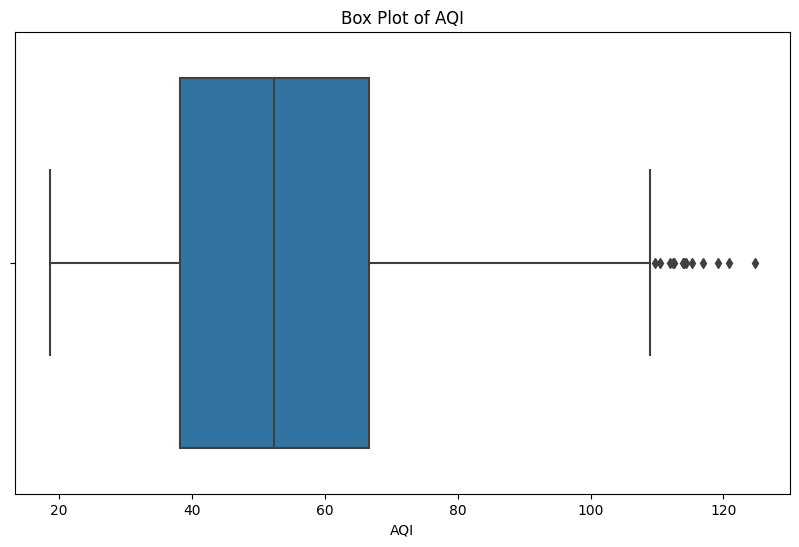

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=air_quality_data['aqi'])
plt.title('Box Plot of AQI')
plt.xlabel('AQI')
plt.show()

In [12]:
data = air_quality_data[['aqi']]

iso = IsolationForest(contamination=0.1)
anomalies = iso.fit_predict(data)

data['anomaly'] = anomalies

median_aqi = data['aqi'].median()
data['corrected'] = np.where(data['anomaly'] == -1, median_aqi, data['aqi'])

# Update the original DataFrame with corrected values
air_quality_data['aqi'] = data['corrected']

Check missing dates

In [13]:
start_date = air_quality_data.index.min()
end_date = air_quality_data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date)

In [14]:
existing_dates = air_quality_data.index
missing_dates = complete_date_range.difference(existing_dates)

In [15]:
print(f"Number of missing dates: {len(missing_dates)}")
print("Missing dates:")
print(missing_dates)

Number of missing dates: 4
Missing dates:
DatetimeIndex(['2020-11-18', '2021-07-31', '2021-08-01', '2023-05-23'], dtype='datetime64[ns]', freq=None)


Use ForwardFill to Cover missing Dates

In [16]:
air_quality_data = air_quality_data.sort_index()  # Ensure data is sorted by date
air_quality_data = air_quality_data.asfreq('D')   # Ensure daily frequency
air_quality_data = air_quality_data.fillna(method='ffill')  # Forward fill missing values

# Data Visualization

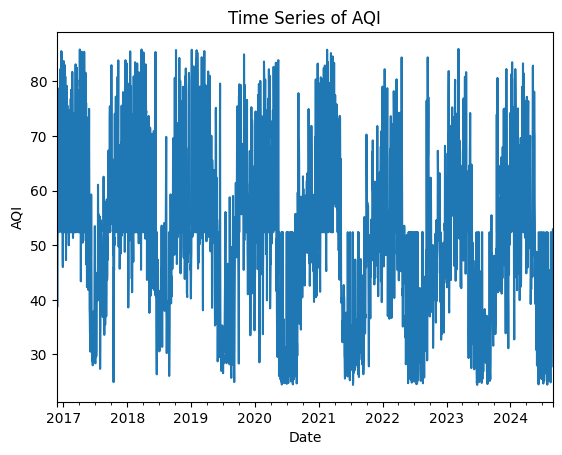

In [17]:
air_quality_data['aqi'].plot()
plt.title('Time Series of AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()

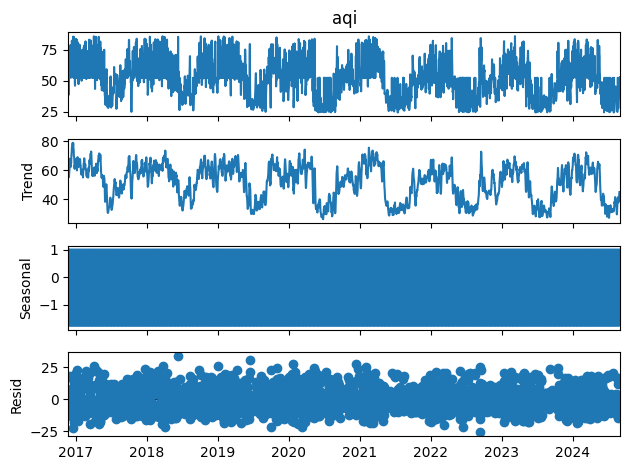

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(air_quality_data['aqi'], model='additive')
result.plot()
plt.show()

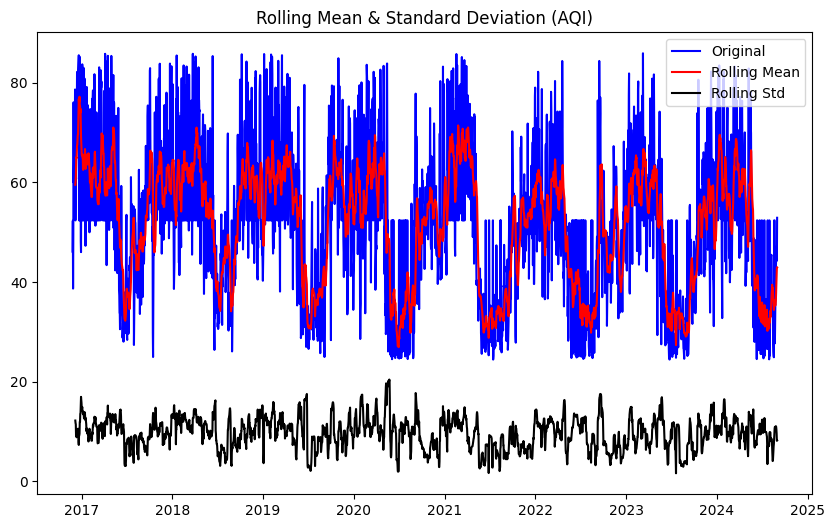

ADF Statistic: -4.324468621714575
p-value: 0.000402813092863537
Critical Values: {'1%': -3.4326726638430176, '5%': -2.862566191457111, '10%': -2.5673162728198173}
The data is stationary, no clear trend.


In [19]:
aqi_data = air_quality_data['aqi']
rolling_mean = aqi_data.rolling(window=12).mean()
rolling_std = aqi_data.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(aqi_data, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (AQI)')
plt.show()

result = adfuller(aqi_data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("The data is stationary, no clear trend.")
else:
    print("The data is not stationary, there is a clear trend.")

# Machine Learning Modeling

In [20]:
aqi_data = air_quality_data['aqi']

In [21]:
# Split data into training and test sets
train_data = aqi_data[:'2024-02-29']  # Training data up to 6 months before the last date
test_data = aqi_data['2024-03-01':]   # Test data (last 6 months)

In [22]:
model = ARIMA(train_data, order=(5, 1, 0))  # You can experiment with different (p,d,q)
model_fit = model.fit()

In [23]:
forecast_test = model_fit.forecast(steps=len(test_data))
conf_int = model_fit.get_forecast(steps=len(test_data)).conf_int()

In [24]:
forecast_test_df = pd.DataFrame({
    'Date': test_data.index,
    'Forecast_AQI': forecast_test,
    'Lower_CI': conf_int.iloc[:, 0],  # Lower confidence interval
    'Upper_CI': conf_int.iloc[:, 1]   # Upper confidence interval
})

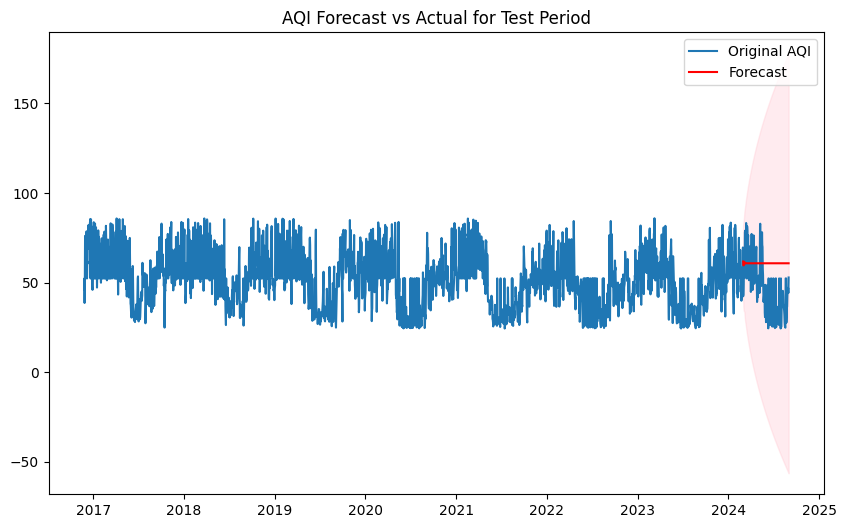

In [25]:
# Plot original vs. forecasted for the test period
plt.figure(figsize=(10, 6))
plt.plot(aqi_data, label='Original AQI')
plt.plot(test_data.index, forecast_test_df['Forecast_AQI'], label='Forecast', color='red')
plt.fill_between(test_data.index, forecast_test_df['Lower_CI'], forecast_test_df['Upper_CI'], color='pink', alpha=0.3)
plt.title('AQI Forecast vs Actual for Test Period')
plt.legend()
plt.show()

In [26]:
# Now re-fit the model to the entire dataset and predict the next 6 months
model_full = ARIMA(aqi_data, order=(5, 1, 0))  # Using full data
model_full_fit = model_full.fit()

In [27]:
# Forecast the next 6 months (after the data)
forecast_next = model_full_fit.forecast(steps=6)
conf_int_next = model_full_fit.get_forecast(steps=6).conf_int()

In [28]:
# Create a DataFrame for the forecasted future period
forecast_dates = pd.date_range(start=aqi_data.index[-1], periods=6, freq='M')
forecast_next_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast_AQI': forecast_next,
    'Lower_CI': conf_int_next.iloc[:, 0],
    'Upper_CI': conf_int_next.iloc[:, 1]
})

In [29]:
# Save the forecast results to a CSV file
forecast_next_df.to_csv('AQI_next_6_months_forecast.csv', index=False)

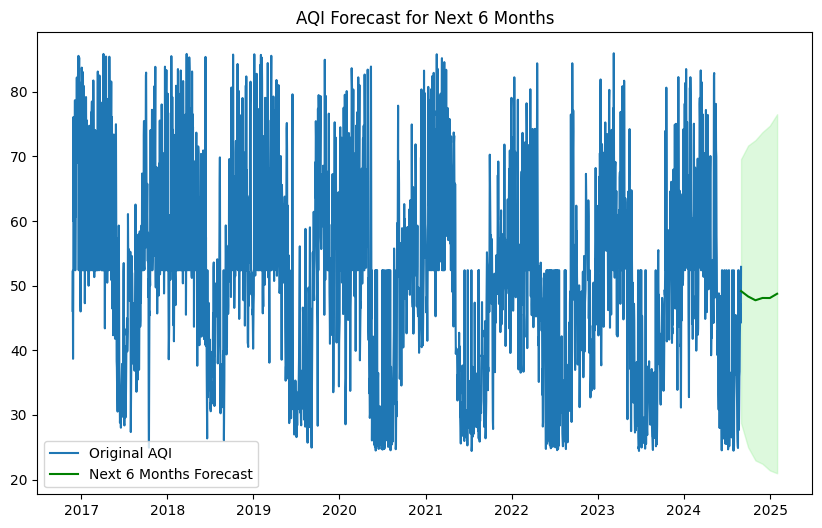

In [30]:
# Plot forecast for the next 6 months
plt.figure(figsize=(10, 6))
plt.plot(aqi_data, label='Original AQI')
plt.plot(forecast_next_df['Date'], forecast_next_df['Forecast_AQI'], label='Next 6 Months Forecast', color='green')
plt.fill_between(forecast_next_df['Date'], forecast_next_df['Lower_CI'], forecast_next_df['Upper_CI'], color='lightgreen', alpha=0.3)
plt.title('AQI Forecast for Next 6 Months')
plt.legend()
plt.show()

In [31]:
forecast_next_df.head(20)

,Date,Forecast_AQI,Lower_CI,Upper_CI
2024-09-01,2024-08-31,49.159083,28.747518,69.570647
2024-09-02,2024-09-30,48.327391,24.986909,71.667873
2024-09-03,2024-10-31,47.737058,22.963186,72.510930
2024-09-04,2024-11-30,48.093197,22.439253,73.747141
2024-09-05,2024-12-31,48.082177,21.423358,74.740997
2024-09-06,2025-01-31,48.745282,20.972908,76.517657


In [32]:
# import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import matplotlib.pyplot as plt

# # Load the air quality data (assuming it's already loaded as air_quality_data)
# aqi_data = air_quality_data['aqi']

# # Split the data: train data up to 2024-08-31
# train_data = aqi_data[:'2024-08-31']

# # Define the SARIMA model (you can adjust the seasonal parameters)
# sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
# sarima_fit = sarima_model.fit(disp=False)

# # Forecasting the next 6 months (approximately 183 days)
# forecast_steps = 183
# forecast_dates = pd.date_range(start='2024-09-01', periods=forecast_steps, freq='D')
# forecast = sarima_fit.get_forecast(steps=forecast_steps)
# forecast_aqi = forecast.predicted_mean
# conf_int = forecast.conf_int()

# # Create a DataFrame for forecast results
# forecast_df = pd.DataFrame({
#     'Date': forecast_dates,
#     'Forecast_AQI': forecast_aqi,
#     'Lower_CI': conf_int.iloc[:, 0],  # Lower confidence interval
#     'Upper_CI': conf_int.iloc[:, 1]   # Upper confidence interval
# })

# # Plot the forecast
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Original AQI')
# plt.plot(forecast_df['Date'], forecast_df['Forecast_AQI'], label='Forecast', color='red')
# plt.fill_between(forecast_df['Date'], forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.3)
# plt.title('Daily AQI Forecast for Next 6 Months')
# plt.legend()
# plt.show()

# # Save the forecast results to a CSV file
# forecast_df.to_csv('AQI_forecast_daily.csv', index=False)

# print(forecast_df)